In [1]:
import os
import sys

current_dir = os.path.abspath(os.path.dirname("Tests_optimization.ipynb"))
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)


from ppe.gradient_optimization import optimize_ppe
import jax.numpy as jnp
import jax.scipy.stats as scs
import matplotlib.pyplot as plt

## Example 1: Simple Gaussian model

We assume $ Y \sim \mathcal{N}(\theta, \sigma)$, with $\theta \sim \mathcal{N}(\mu_1, \sigma_1)$. Then, we have the hyperparameter vector $\pmb{\lambda} = [\mu_1, \sigma, \sigma_1]$. Also, for $ A = (a,b] $, we know that 

$$\mathbb{P}_{A|\pmb{\lambda}} = \Phi \Big((b - \mu_1)/\sqrt{\sigma^2 + \sigma_1^2} \Big) - \Phi \Big((a - \mu_1)/\sqrt{\sigma^2 + \sigma_1^2} \Big)$$

### Optimizing $\lambda$ only

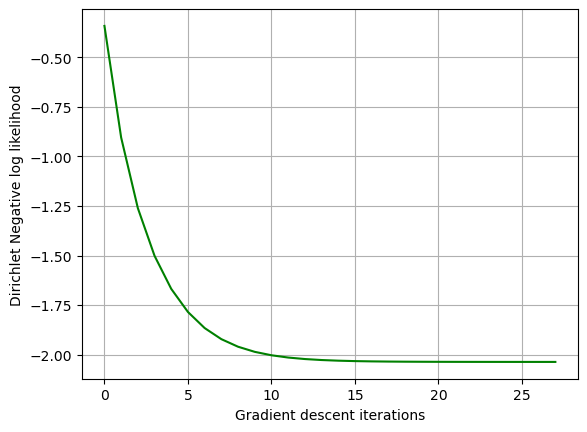

In [8]:
## We define the prior predictive distribution (ppd) for the gaussian model:

def get_gaussian_probs(partition, lam):


    mu_1 = lam[0]
    sigma = lam[1]
    sigma_1 = lam[2]

    p1 = scs.norm.cdf((partition[1] - mu_1)/jnp.sqrt(sigma**2 + sigma_1**2)) - scs.norm.cdf((partition[0] - mu_1)/jnp.sqrt(sigma**2 + sigma_1**2))

    return p1


### The lower and upper partitions should be wide enough so that the probabilities sum to 1

partitions = [jnp.array([[-1000,-2], [-2, 3], [3, 1000]])]

expert_probs = [jnp.array([0.2, 0.7, 0.1])]

J = 1


opt_class = optimize_ppe(alpha=6, J=J, ppd=get_gaussian_probs)




lam_new, lik_progression, grad_progression = opt_class.gradient_descent(partitions, expert_probs, lam_0=jnp.ones(3)*2, iters = 500, step_size=0.2, tol = 1e-5)



plt.plot(lik_progression, color="Green", linewidth=1.5)
plt.xlabel("Gradient descent iterations")
plt.ylabel("Dirichlet Negative log likelihood")
plt.grid(True)
plt.savefig("/Users/panos/Desktop/Internship/Report_figures/simple_gaussian_lik.pdf", format='pdf')
plt.show()


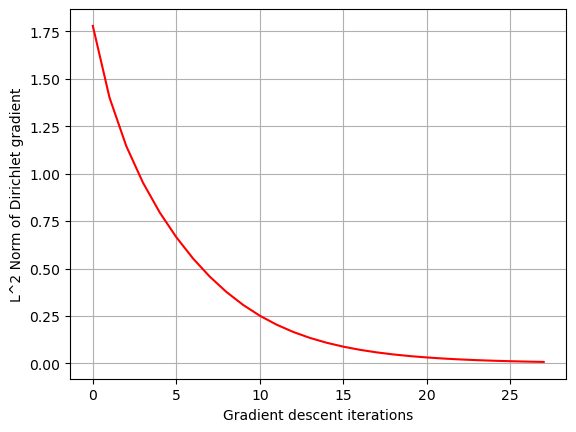

In [9]:
plt.plot(grad_progression, color="Red", linewidth=1.5)
plt.xlabel("Gradient descent iterations")
plt.ylabel("L^2 Norm of Dirichlet gradient")
plt.grid(True)
plt.savefig("/Users/panos/Desktop/Internship/Report_figures/simple_gaussian_grad.pdf", format='pdf')

plt.show()

In [10]:
lam_new


Array([0.07748684, 1.9856238 , 1.9856238 ], dtype=float32)

In [11]:
opt_class.get_alpha(partitions, lam_new, expert_probs)


Array(58.40913, dtype=float32)

In [6]:
[opt_class.ppd_function(partition, lam_new) for partition in partitions]


[Array([0.2297045 , 0.6212986 , 0.14899689], dtype=float32)]

In [7]:
expert_probs


[Array([0.2, 0.7, 0.1], dtype=float32)]

### Optimizing both $\alpha$ and $\lambda$

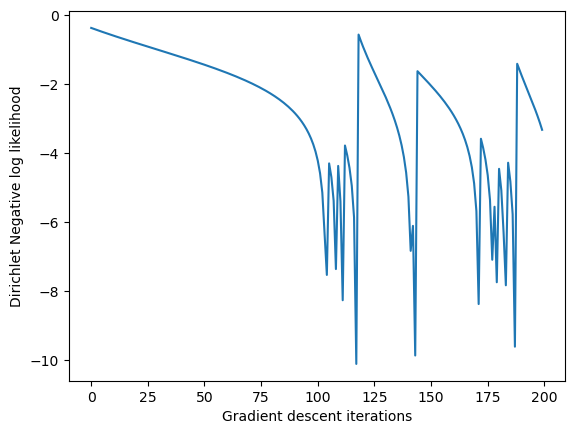

In [17]:
#### Does not converge


partitions = [jnp.array([[-1000,-2], [-2, 3], [3, 1000]])]

expert_probs = [jnp.array([0.2, 0.7, 0.1])]

J = 1

opt_class = optimize_ppe(alpha=None, J = J, ppd=get_gaussian_probs)


lam_new, lik_progression, grad_progression = opt_class.gradient_descent(partitions, expert_probs, lam_0=jnp.ones(3)*2, iters = 200, step_size=0.01, tol = 1e-5)

plt.plot(lik_progression)
plt.xlabel("Gradient descent iterations")
plt.ylabel("Dirichlet Negative log likelihood")
plt.show()

In [18]:
lam_new

Array([0.40454125, 1.5750107 , 1.5750107 ], dtype=float32)

In [19]:
opt_class.get_alpha(partitions, lam_new, expert_probs)


Array(75.410515, dtype=float32)

In [20]:
[opt_class.ppd_function(partition, lam_new) for partition in partitions]

[Array([0.14017634, 0.7378628 , 0.12196082], dtype=float32)]

## Second example: binary classification in the presence of covariates (taken from the paper)

We consider a generative model for binary data in the presence of a vector of covariates. The observable variable conditioned on the parameters is distributed according to a Bernoulli model and we take a multivariate Gaussian distribution as the prior distribution for the vector of parameters in the predictor function. This can be formalized as:

$$ y|\pmb{\theta} \sim \pmb{\mathcal{B}(\Phi (\pmb{x}^{\text{T}}\pmb{\theta}))}, $$

where

$$\pmb{\theta} \sim \mathcal{N}_D(\mu, \Sigma).$$

This gives us

$$ y \sim \mathcal{B}(p(\pmb{x}, \pmb{\lambda})),$$

where 

$$ p(\pmb{x}, \pmb{\lambda}) = \Phi \Big(\frac{\pmb{x}^{\text{T}}\pmb{\mu}}{\sqrt{1 + \pmb{x}^{\text{T}}\Sigma\pmb{x}}}\Big).$$

Our hyperparameter set is defined as $\pmb{\lambda} = [\mu, \Sigma]$. Since we have binary classification, there are only two partitions, ${0,1}$. If we define $A_1 = \mathbb{P}(y=0)$ and $A_2 = \mathbb{P}(y=1)$ we get:

$$\mathbb{P}_{A_1 | \pmb{\lambda}} = 1 -  p(\pmb{x}^{\text{T}}\pmb{\lambda}) \text{ and } \mathbb{P}_{A_2 | \pmb{\lambda}} = p(\pmb{x}^{\text{T}}\pmb{\lambda}).$$

For this example we assume $D=5$ and that the variables are independent with one another, meaning that $\Sigma$ is a diagonal matrix.

### Optimizing $\lambda$ only

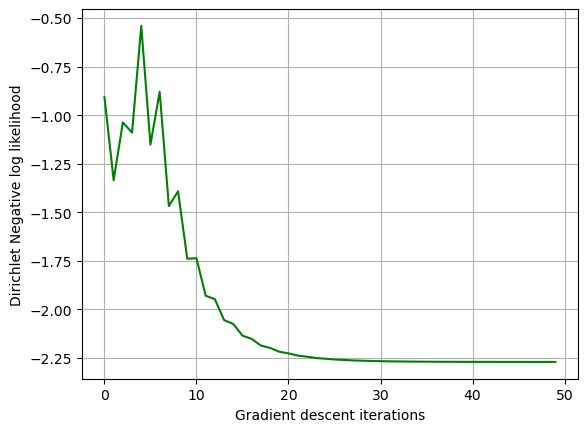

In [21]:
def get_bernoulli_probs(partition, lam, covariate_set):

    nom = jnp.inner(jnp.array(lam[:5]), covariate_set)
    den = jnp.sqrt(1 + covariate_set.T@jnp.diag(jnp.array(lam[5:]))@covariate_set)

    p1 = 1 - scs.norm.cdf(nom / den)

    if partition == 0:
        return p1

    return 1 - p1


partitions = [jnp.array([0,1]),
              jnp.array([0,1]),
              jnp.array([0,1])]

expert_probs = [jnp.array([0.35, 0.65]),
                jnp.array([0.3, 0.7]),
                jnp.array([0.2, 0.8])]

total_covariate_sets = [jnp.array([1.3, 0.7, 0.5, -0.7, -0.5]),
                        jnp.array([1, 0.5, 0.4, -0.8, 0]),
                        jnp.array([0.3, 0.7, 2, -2, 0.2])]

J = 3

opt_class = optimize_ppe(alpha=6, J = J, ppd=get_bernoulli_probs)




lam_new, lik_progression, grad_progression = opt_class.gradient_descent(partitions, expert_probs, lam_0=jnp.ones(10)*2.0, iters = 1000, step_size=0.5, tol = 1e-5, total_covariates=total_covariate_sets)


plt.plot(lik_progression, color="Green", linewidth=1.5)
plt.xlabel("Gradient descent iterations")
plt.ylabel("Dirichlet Negative log likelihood")
plt.grid(True)
plt.show()

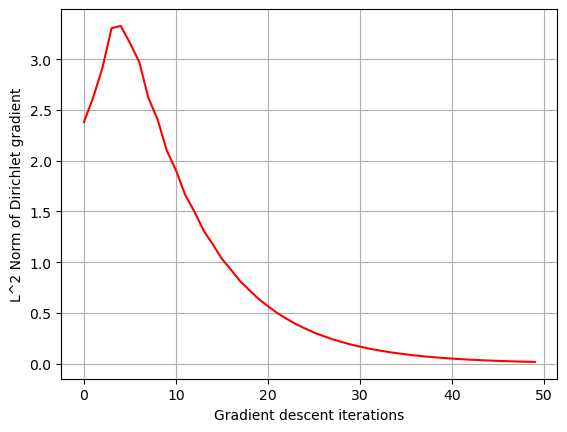

In [22]:
plt.plot(grad_progression, color="Red", linewidth=1.5)
plt.xlabel("Gradient descent iterations")
plt.ylabel("L^2 Norm of Dirichlet gradient")
plt.grid(True)
plt.show()

In [23]:
lam_new

Array([0.76263016, 1.672591  , 2.5764468 , 1.8593926 , 2.3115544 ,
       2.9431057 , 2.284746  , 2.3962924 , 2.6813037 , 2.0747192 ],      dtype=float32)

In [24]:
opt_class.get_alpha(partitions, lam_new, expert_probs, total_covariate_sets)


Array(164.46776, dtype=float32)

In [25]:
[jnp.array(opt_class.ppd_function(partitions[j], lam_new, total_covariate_sets[j])) for j in range(J)]


[Array([0.37380856, 0.62619144], dtype=float32),
 Array([0.32850063, 0.6714994 ], dtype=float32),
 Array([0.24490458, 0.7550954 ], dtype=float32)]

### Optimizing both $\alpha$ and $\lambda$

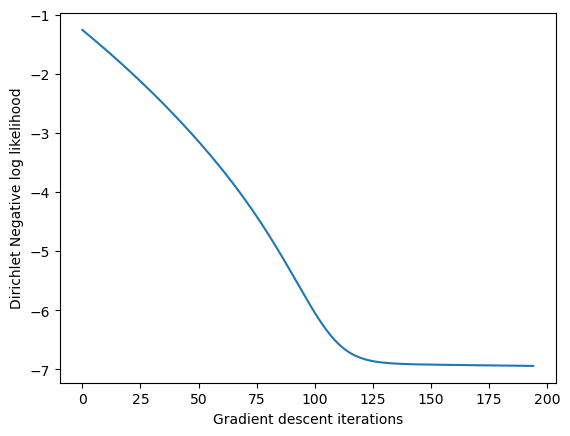

In [26]:
def get_bernoulli_probs(partition, lam, covariate_set):

    nom = jnp.inner(jnp.array(lam[:5]), covariate_set)
    den = jnp.sqrt(1 + covariate_set.T@jnp.diag(jnp.array(lam[5:]))@covariate_set)

    p1 = 1 - scs.norm.cdf(nom / den)

    if partition == 0:
        return p1

    return 1 - p1




partitions = [jnp.array([0,1]),
              jnp.array([0,1]),
              jnp.array([0,1]),
              jnp.array([0,1])]

expert_probs = [jnp.array([0.35, 0.65]),
                jnp.array([0.3, 0.7]),
                jnp.array([0.2, 0.8]),
                jnp.array([0.1, 0.9])]

total_covariate_sets = [jnp.array([1.3, 0.7, 0.5, -0.7, -0.5]),
                        jnp.array([1, 0.5, 0.4, -0.8, 0]),
                        jnp.array([0.3, 0.7, 2, -2, 0.2]),
                        jnp.array([-0.3, 0.7, 3, -3, 0.4])]

J = 4


opt_class = optimize_ppe(alpha=None, J = J, ppd=get_bernoulli_probs)
lam_new, lik_progression, grad_progression = opt_class.gradient_descent(partitions, expert_probs, lam_0=jnp.ones(10), iters = 500, step_size=0.002, tol = 1e-4, total_covariates=total_covariate_sets)


plt.plot(lik_progression)
plt.xlabel("Gradient descent iterations")
plt.ylabel("Dirichlet Negative log likelihood")
plt.show()

In [27]:
lam_new

Array([0.21732779, 0.8336564 , 1.6224473 , 0.49700898, 1.2194144 ,
       1.091725  , 1.043155  , 0.839035  , 0.86574966, 1.0004443 ],      dtype=float32)

In [28]:
opt_class.get_alpha(partitions, lam_new, expert_probs, total_covariate_sets) ## resulting alpha from the MLE closed form solution for the optimized hyperparameters lambda


Array(88.42014, dtype=float32)

In [29]:
best_model_probs = [jnp.array(opt_class.ppd_function(partitions[j], lam_new, total_covariate_sets[j])) for j in range(len(expert_probs))]


In [30]:
best_model_probs


[Array([0.36335516, 0.63664484], dtype=float32),
 Array([0.30579156, 0.69420844], dtype=float32),
 Array([0.14002275, 0.85997725], dtype=float32),
 Array([0.14470935, 0.85529065], dtype=float32)]